# CS4320 - Introduction to Machine Learning 

## Homework 3: Preprocessing 

**Please type your name and A number here:**

In [1]:
Name = "Carson Fox"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

A_number = "A02251670"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

## Imports 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [3]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

### 1. Data splitting
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

  Split the data into `train_df` (50%) and `test_df` (50%) with `random_state = 10`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.

(_Usually having more data for training is a good idea. But here I'm using 50%/50% split because this is kind of a big dataset for a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_)

In [4]:
train_df, test_df = train_test_split(census_df, train_size=.5, random_state=10)

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [5]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32544,72,?,129912,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,25,United-States,<=50K
32545,45,Local-gov,119199,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Female,0,0,48,United-States,<=50K
32547,39,Local-gov,111499,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,>50K
32551,43,Self-emp-not-inc,27242,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [6]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(16280, 15)

In [7]:
train_df_nan.sort_index() # The "?" symbols are now replaced with NaN values. 

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32544,72,NaN,129912,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,United-States,<=50K
32545,45,Local-gov,119199,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Female,0,0,48,United-States,<=50K
32547,39,Local-gov,111499,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,>50K
32551,43,Self-emp-not-inc,27242,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K


### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, you can optimally use the `include="all"` argument to show summary statistics of all  features. {points:2}
2. Visualize the histograms of numeric features (Hint: use "df.hist" to show the distribution of numeric features). {points:4} 
3. From the visualizations, which features seem relevant for the given prediction task?(You can pick multi-features). {points:4}

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [8]:
train_df_nan.info()
train_df_nan.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16280 entries, 27978 to 17673
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       15403 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education.num   16280 non-null  int64 
 5   marital.status  16280 non-null  object
 6   occupation      15398 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital.gain    16280 non-null  int64 
 11  capital.loss    16280 non-null  int64 
 12  hours.per.week  16280 non-null  int64 
 13  native.country  15998 non-null  object
 14  income          16280 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.0+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,16280.00000,15403,1.628000e+04,16280,16280.000000,16280,15398,16280,16280,16280,16280.000000,16280.000000,16280.000000,15998,16280
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,11404,NaN,5259,NaN,7498,2076,6582,13890,10887,NaN,NaN,NaN,14564,12355
mean,38.55731,NaN,1.896666e+05,NaN,10.095885,NaN,NaN,NaN,NaN,NaN,1101.524570,86.944287,40.569656,NaN,NaN
std,13.53856,NaN,1.047738e+05,NaN,2.573179,NaN,NaN,NaN,NaN,NaN,7518.801962,403.082228,12.394589,NaN,NaN
min,17.00000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.00000,NaN,1.178330e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.00000,NaN,1.780250e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.00000,NaN,2.369410e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education.num'}>,
        <AxesSubplot:title={'center':'capital.gain'}>],
       [<AxesSubplot:title={'center':'capital.loss'}>,
        <AxesSubplot:title={'center':'hours.per.week'}>]], dtype=object)

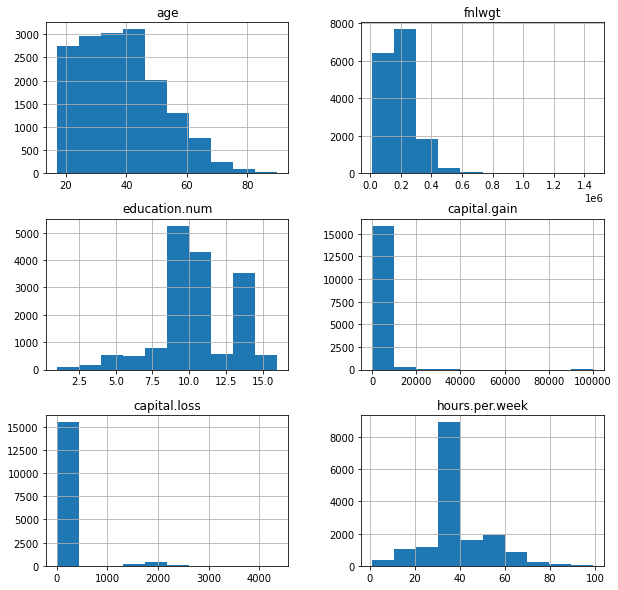

In [9]:
train_df_nan.hist(figsize=(10, 10))

Age and education seem most relevant. They're more evenly distributed and clearly relevant to income.

### 2.2 Identify transformations to apply
rubric={points:20}

**Your tasks:**
1. Identify what kind of feature transformations you would apply on each column in the dataset and fill in the table below accordingly. You may decide to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. We use imputation and One-Hot encoding for feature occupation here. {points: 13} 
2. Identify different feature types for applying different transformations. In particular, fill in the lists below. {points: 5} 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. {points: 2}

> Note: This question is a bit open-ended and there is no single correct solution.

Task 1:
Fill in the table with feature transformation techniques. You can drop this column by filling in "drop".{points:13}

| Feature | Transformation |
| --- | ----------- |
| occupation | Imputation, One-Hot Encoding |
| age | Scaling |
| workclass | Imputation, One-Hot Encoding |
| fnlwgt | scaling |
| education | Ordinal Encoding |
| education.num | scaling |
| marital.status | One-Hot Encoding |
| relationship | One-Hot Encoding |
| race | One-Hot Encoding |
| sex | One-Hot Encoding |
| capital.gain | Scaling |
| capital.loss | Scaling |
| hours.per.week | Scaling |
| native.country | One-Hot Encoding |


In [10]:
# Task 2: fill in the lists with feature name.
# Example: numeric_features = ["age"] 
# It's OK to keep some of the lists empty or add new lists.{points:5}
# Features lists
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'] 
categorical_features = ['occupation', 'workclass', 'marital.status', 'relationship', 'race', 'sex', 'native.country'] 
ordinal_features = ['education']
binary_features = []
drop_features = []  # do not include these features in modeling
passthrough_features = [] # do not apply any transformation

target = "income"

Task 3: Is including the `race` feature for predicting income ethically a good idea? Briefly discuss.{points:2}

Yes, because race has a very obvious correlation with income. The ethical considerations are involved in how the model is used; for example, it would not be ethical to use such a model to decide eligibility for a loan, because it will learn the biases in the training data.

### 2.3 Separating feature vectors and targets  
rubric={points:6}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. {points: 4}
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? {points: 2}

In [11]:
X_train = train_df_nan[numeric_features + categorical_features + ordinal_features]
y_train = train_df_nan[target]

X_test = test_df_nan[numeric_features + categorical_features + ordinal_features]
y_test = test_df_nan[target]

Task 2: 
No, we haven't performed any transformations like one-hot encoding yet.

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. {points: 10}
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? {points: 4} 
3. Why do we need to use a column transformer in this case? Briefly explain. {points: 4} 

In [12]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    (OrdinalEncoder(), ordinal_features),
)

In [13]:
X_transformed = preprocessor.fit_transform(X_train)
X_transformed.shape

(16280, 92)

Task 3: We use a column transformer because we want to apply different transformations to different columns.

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [14]:
results_dict = {}  # dictionary to store all the results

In [15]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier. {points:3} 
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  {points:3} 

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [16]:
pipeline = make_pipeline(preprocessor, DummyClassifier(strategy='prior'))

In [17]:
mean_std_cross_val_scores(pipeline, X_train, y_train, cv=5)

fit_time      0.024 (+/- 0.001)
score_time    0.009 (+/- 0.001)
test_score    0.759 (+/- 0.000)
dtype: object

### 4.2 Trying different classifiers
rubric={points:12}

**Your tasks:**

1. For each of the models in the starter code below: {points: 5}
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. {points: 2}
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one(Pick one from: Dummy classifier, decision tree, KNN, SVM)? {points: 5} 

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [18]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

In [19]:
for label, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    results_dict[label] = mean_std_cross_val_scores(pipeline, X_train, y_train, cv=5)

In [20]:
results_df = pd.DataFrame(results_dict)
results_df

,decision tree,kNN,RBF SVM
fit_time,0.329 (+/- 0.007),0.027 (+/- 0.001),2.756 (+/- 0.038)
score_time,0.010 (+/- 0.000),1.105 (+/- 0.023),0.507 (+/- 0.003)
test_score,0.809 (+/- 0.007),0.829 (+/- 0.008),0.852 (+/- 0.008)


Task 3: All models only slightly outperform the dummy model. The best is RBF SVM. The decision tree was the fastest to score, but the KNN model was the fastest to fit.

### 4.3 Exploring importance of scaling
rubric={points:10}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. {points:4} 
2. Repeat the steps in 4.2 with this new column transformer. Save all results in "results_dic_compare" {points: 4}
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not? {points:2}

In [21]:
results_dict_compare = {}  # dictionary to store all the results

In [22]:
preprocessor = make_column_transformer(
    #(StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    (OrdinalEncoder(), ordinal_features),
)

In [23]:
for label, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    results_dict_compare[label] = mean_std_cross_val_scores(pipeline, X_train, y_train, cv=5)

In [24]:
results_df = pd.DataFrame(results_dict_compare)
results_df

,decision tree,kNN,RBF SVM
fit_time,0.159 (+/- 0.003),0.021 (+/- 0.001),3.330 (+/- 0.047)
score_time,0.008 (+/- 0.001),1.168 (+/- 0.022),0.524 (+/- 0.004)
test_score,0.810 (+/- 0.010),0.807 (+/- 0.008),0.818 (+/- 0.009)


While the other classifiers' accuracies suffered after removing the scaler, the decision tree's did not. This indicates that scaling is unnecessary for decision trees. This is because they divide samples by comparing each feature to a learned threshold. When scaling is removed this threshold changes, but the decisions it makes based on that feature remains the same.

### 4.4 Hyperparameter optimization
rubric={points:8}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. {points:4} 
2. The hyperparameter `C = 1.0` is the default value in `scikit-learn`. Does this default value (`C = 1.0`) seem reasonable, meaning it is performing the best or comparable to the best `C` values? {points:4}

> Note: Running this might take a while.(Waite patiently: about 9 min on colab) 

In [25]:
param_grid = {"C": np.logspace(-2, 2, 5)}
param_grid

{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}

In [26]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    (OrdinalEncoder(), ordinal_features),
)

In [27]:
results_dict = {}

In [28]:
for c in param_grid['C']:
    pipeline = make_pipeline(preprocessor, SVC(C=c))
    results_dict[c] = mean_std_cross_val_scores(pipeline, X_train, y_train, cv=5)

In [29]:
pd.DataFrame(results_dict)

,0.01,0.10,1.00,10.00,100.00
fit_time,3.629 (+/- 0.054),3.208 (+/- 0.047),2.760 (+/- 0.043),2.939 (+/- 0.046),4.325 (+/- 0.080)
score_time,0.667 (+/- 0.002),0.609 (+/- 0.003),0.510 (+/- 0.004),0.474 (+/- 0.004),0.468 (+/- 0.005)
test_score,0.764 (+/- 0.001),0.834 (+/- 0.002),0.852 (+/- 0.008),0.855 (+/- 0.007),0.852 (+/- 0.004)


Task 2:
C = 1.0 seems like a resonable default. Of the c values tested, it outperforms smaller values and is very close to larger values.

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:6}

**Your tasks:**

1. Train the best performing model on the entire training set. {points:2} 
2. Report the results of this model on `X_test`. Hint: Categorical features may be different in training set and test set. So, when you make your preprocessor, you need to make argment "handle_unknown='ignore'" {points: 2}
3. Are the cross-validation results and test results consistent? {points:2} 

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (OrdinalEncoder(), ordinal_features),
)
pipeline = make_pipeline(preprocessor, SVC(C=10))

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['occupation', 'workclass',
                                                   'marital.status',
                                                   'relationship', 'race',
                                                   'sex', 'native.country']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['education'])])),
                ('svc', SVC(C=10))])

In [33]:
accuracy_score(y_test, pipeline.predict(X_test))

0.8525274860266568

In [34]:
mean_std_cross_val_scores(pipeline, X_test, y_test, cv=5)

fit_time      2.893 (+/- 0.030)
score_time    0.473 (+/- 0.005)
test_score    0.853 (+/- 0.004)
dtype: object

Task 3:
Yes, the results agree to within the tolerance reported.

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and delete any throwaway code.